# Replicating Lin et al. (2008): Study 2

In [1]:
# Import packaqes
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from decimal import *
%matplotlib inline

In [2]:
# Define Parameters
sigma = 1.0 #shear
lam = 0.1 #damping
A = 0.1 #kick amplitude
#T = 2 #time interval of kicks

In [3]:
# Build Map reduction of dynamics: Lin. et al equation 5
def H(theta):
    return np.sin(2*np.pi*theta)

def rand_T(mean_T):
    return np.random.exponential(mean_T)

def rand_T_uniform(mean_T):
    return np.random.uniform(0, mean_T)

def rand_T_gaus(mean_T):
    return np.random.normal(mean_T, mean_T/10.0)

def rand_T_deter(mean_T):
    return mean_T

def rand_T_cauchy(mode_T):
    return np.random.standard_cauchy() + mode_T

def f_map(theta,y,lam, sigma, T, A): # for theta
    return (theta + T + (sigma/lam)*(y + A*H(theta))*(1 - np.exp(-lam*T))) % 1

def g_map(theta, y, lam, T, A): # for y
    return np.exp(-lam*T)*(y + A*H(theta))

In [4]:
# Compute Jacobian of map reduction
c2 = sigma/lam

def jac1(theta, T, A):
    c3 = 2*np.pi*A*np.cos(2*np.pi*theta)
    c1 = np.exp(-lam*T)
    
    # see: https://docs.python.org/3/library/decimal.html
    return np.array([[Decimal((1 + c2*c3*(1-c1))), Decimal((c2*(1-c1)))],
                     [Decimal((c1*c3)), Decimal(c1)]]) 

In [8]:
# Run test simulations
Ts = np.linspace(0.1,20,40)
def test_sim(rand_T_func, vary_A = True):
    
    sim_ly_s = []

    for t in tqdm.tqdm(Ts):
        T = t # set time between kicks

        max_run = 10 # no. of replications
        max_iter = 1000 # no. of map iterations

        run_ly_s = []

        # Run with fixed parameter values
        for i in range(max_run):

            # random initial state
            theta_T = np.random.uniform(0,1)
            y_T = np.random.uniform(-0.1, 0.1)

            # generate unit tangent vector
            u = np.array([0,1]).T
            log_arg = u # initialize log argument for lyapunov exponent

            for j in range(max_iter):
                    # Determine time of next kick
                T_kick = rand_T_func(T)
                if vary_A:
                    A_kick = A*np.random.uniform(0.8,1.2)
                else:
                    A_kick = A

                # Update jacobian product
                log_arg = jac1(theta_T, T_kick, A_kick).dot(log_arg)

                # Update system state: (theta,y)
                theta_T = f_map(theta_T, y_T, lam, sigma, T_kick, A_kick)
                y_T = g_map(theta_T, y_T, lam, T_kick, A_kick)

            # Store run values
            run_ly_s.append(float(Decimal(np.linalg.norm(log_arg)).ln()/max_iter))

        # Store max lyapunov exponents
        sim_ly_s.append(np.max(run_ly_s))
    return sim_ly_s

In [14]:
# sim_ly_s_exp = test_sim(rand_T)
# sim_ly_s_exp_b = test_sim(rand_T, vary_A = False)
sim_ly_s_unif = test_sim(rand_T_uniform)
sim_ly_s_unif_b = test_sim(rand_T_uniform, vary_A = False)
# sim_ly_s_deter = test_sim(rand_T_deter, vary_A = False)
# sim_ly_s_deter_b = test_sim(rand_T_deter)
# sim_ly_s_gaus = test_sim(rand_T_gaus)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.06it/s]


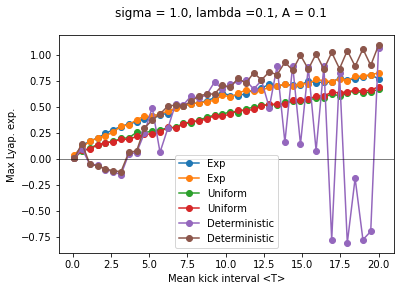

In [15]:
# Plot max lyapunov exponents
plt.plot(Ts, sim_ly_s_exp, 'o-', label = "Exp")
plt.plot(Ts, sim_ly_s_exp_b, 'o-', label = "Exp")
plt.plot(Ts, sim_ly_s_unif, 'o-', label = "Uniform")
plt.plot(Ts, sim_ly_s_unif_b, 'o-', label = "Uniform")
plt.plot(Ts, sim_ly_s_deter, 'o-', label = "Deterministic")
plt.plot(Ts, sim_ly_s_deter_b, 'o-', label = "Deterministic")
# plt.plot(Ts, sim_ly_s_gaus, 'ro-', label = "Normal")
plt.axhline(y=0, color='k', linewidth= 0.5)
plt.xlabel('Mean kick interval <T>')
plt.ylabel('Max Lyap. exp.')
plt.legend()
plt.suptitle('sigma = {}, lambda ={}, A = {}'.format(sigma,lam,A))
plt.show()